## dataload & FeatureEngineering

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sys
plt.style.use('seaborn')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno
import pandas as pd
pd.set_option('display.min_rows', 500)
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../LGBM/')
from utils import apply_elo_granularity_feature_name


def concat_and_export(train_fe, test_fe):
    
    train_fe['kind']='train'
    test_fe['kind']='test'
    
    df = pd.concat([train_fe,test_fe])
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/after_fe_train_test_cumsum.pkl'
    df.to_pickle(write_path,index=False)
    print(f"Write: {write_path}")
    
def export(df, output='after_fe_train_test.pkl'):
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/{output}'
    df.to_pickle(write_path)
    print(f"Write: {write_path}")
    
path='../../data/'
train = pd.read_csv(f"{path}/train_data.csv")
test = pd.read_csv(f"{path}/test_data.csv")

day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}

def feature_engineering(df):
    uid2idx = {v:k for k,v in enumerate(sorted(df.userID.unique()))}
    ass2idx = {v:k for k,v in enumerate(sorted(df.assessmentItemID.unique()))}
    test2idx = {v:k for k,v in enumerate(sorted(df.testId.unique()))}

    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    # userID, assessmentItemID, testId 라벨인코딩
    df2['uidIdx'] = df2.userID.map(uid2idx)
    df2['assIdx'] = df2.assessmentItemID.map(ass2idx)
    df2['testIdx'] = df2.testId.map(test2idx)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['month'] = pd.to_datetime(df2.Timestamp).dt.month
    df2['day'] = pd.to_datetime(df2.Timestamp).dt.day
    df2['hour'] = pd.to_datetime(df2.Timestamp).dt.hour
    df2['dayname'] = pd.to_datetime(df2.Timestamp).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    # 유저별 문제푼 시간, solvesec_3600, time_category
    df2['Timestamp2'] = pd.to_datetime(df2.Timestamp)
    df2['solvetime'] = df2.groupby('userID')['Timestamp2'].diff().fillna(pd.Timedelta(seconds=0))
    df2['solvesec'] = df2.solvetime.map(lambda x : x.total_seconds())
    df2['solvesec_3600'] = df2.solvesec
    df2.loc[df2.solvesec>=3600,'solvesec_3600']=3600

    df2['time_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600]
    df2.loc[(df2.solvesec==0), 'time_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec>s) & (df2.solvesec<=e),'time_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec>=tc[-1]),'time_category'] = f"{i+2} - ({e}, )"
    timecat2idx={k:v for v,k in enumerate(sorted(df2.time_category.unique()))}
    df2['time_category'] = df2.time_category.map(timecat2idx)
    
    # 유저별 문제푼 시간 Cumsum
    df2['solvesec_cumsum'] = df2.groupby(['userID','testId'])['solvesec_3600'].cumsum()%3601
    df2['solvecumsum_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600,7200]
    df2.loc[(df2.solvesec_cumsum==0), 'solvecumsum_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec_cumsum>s) & (df2.solvesec_cumsum<=e),'solvecumsum_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec_cumsum>=tc[-1]),'solvecumsum_category'] = f"{i+2} - ({e}, )"
    solvecumsum_category2idx={k:v for v,k in enumerate(sorted(df2.solvecumsum_category.unique()))}
    df2['solvecumsum_category'] = df2.solvecumsum_category.map(solvecumsum_category2idx)
    
    ## big_category
    # big_category 전체 정답률, 표준편차
#     big_category_answermean = dict(df2.groupby("big_category").answerCode.mean())
#     big_category_answerstd = dict(df2.groupby("big_category").answerCode.std())
#     df2['big_category_acc'] = df2.big_category.map(big_category_answermean)
#     df2['big_category_std'] = df2.big_category.map(big_category_answerstd)

    # 유저별 big category 문제 푼 횟수, 맞춤 횟수, 누적 정답률
    df2['big_category_cumconut'] = df2.groupby(['userID','big_category']).answerCode.cumcount()
    df2['big_category_answer'] = df2.groupby(['userID','big_category']).answerCode.transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df2['big_category_user_cum_acc'] = (df2['big_category_answer'] / df2['big_category_cumconut']).fillna(0)
    
    # 유저별 정답률, 표준 편차 (마지막제출 제외)
#     df2_user_big_ans = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','big_category']).answerCode.mean().reset_index()
#     df2_user_big_ans.rename(columns={'answerCode':'big_category_user_acc'},inplace=True)
#     df2 = df2.merge(df2_user_big_ans,on=['userID','big_category'])
    
#     df2_user_big_ans_std = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','big_category']).answerCode.std().reset_index()
#     df2_user_big_ans_std.rename(columns={'answerCode':'big_category_user_std'},inplace=True)
#     df2 = df2.merge(df2_user_big_ans_std,on=['userID','big_category'])   
    
    ## mid_category
    # mid_category 전체 정답률, 표준편차
#     mid_category_answermean = dict(df2.groupby("mid_category").answerCode.mean())
#     mid_category_answerstd = dict(df2.groupby("mid_category").answerCode.std())
#     df2['mid_category_acc'] = df2.mid_category.map(mid_category_answermean)
#     df2['mid_category_std'] = df2.mid_category.map(mid_category_answerstd)

    # 유저별 mid category 문제 푼 횟수, 맞춤 횟수, 누적 정답률
    df2['mid_category_cumconut'] = df2.groupby(['userID','mid_category']).answerCode.cumcount()
    df2['mid_category_answer'] = df2.groupby(['userID','mid_category']).answerCode.transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df2['mid_category_user_cum_acc'] = (df2['mid_category_answer'] / df2['mid_category_cumconut']).fillna(0)

    # 유저별 정답률, 표준 편차 (마지막제출 제외)
#     df2_user_mid_ans = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','mid_category']).answerCode.mean().reset_index()
#     df2_user_mid_ans.rename(columns={'answerCode':'mid_category_user_acc'},inplace=True)
#     df2 = df2.merge(df2_user_mid_ans,on=['userID','mid_category'])

#     df2_user_mid_ans_std = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','mid_category']).answerCode.std().reset_index()
#     df2_user_mid_ans_std.rename(columns={'answerCode':'mid_category_user_std'},inplace=True)
#     df2 = df2.merge(df2_user_mid_ans_std,on=['userID','mid_category']) 


    ### 문항별 난이도
    ass_acc_dict = dict(df2[df2.answerCode!=-1].groupby('assessmentItemID').answerCode.mean())
    df2['ass_acc_mean'] = df2.assessmentItemID.map(ass_acc_dict)
    df2['ass_difficulty'] = 1 - df2['ass_acc_mean']
    
    ass_acc_std_dict = dict(df2[df2.answerCode!=-1].groupby('assessmentItemID').answerCode.std())
    df2['ass_acc_std'] = df2.assessmentItemID.map(ass_acc_std_dict)

    ### 문제 번호별 난이도
    pb_num_dict = dict(df2[df2.answerCode!=-1].groupby('problem_num').answerCode.mean())
    df2['pb_num_acc_mean'] = df2.problem_num.map(pb_num_dict)
    df2['pb_num_difficulty'] = 1 - df2['pb_num_acc_mean']
    
    pb_num_std_dict = dict(df2[df2.answerCode!=-1].groupby('problem_num').answerCode.std())
    df2['pb_num_acc_std'] = df2.problem_num.map(pb_num_std_dict)
    
    ## assess_count
    df2['assess_count'] = df2.groupby(['userID','assessmentItemID']).answerCode.cumcount()
    
    ## apply elo
    df2 = apply_elo_granularity_feature_name(df2, "assessmentItemID")
    df2 = apply_elo_granularity_feature_name(df2, "problem_num")
    
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    return df2

train['kind']='train'
test['kind']='test'
df = pd.concat([train,test])
df = feature_engineering(df)
df2=df.copy()

Dataset of shape (2526700, 47)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote']
Parameter estimation is starting...


100%|██████████████████████████████| 2526700/2526700 [00:16<00:00, 156659.54it/s]


Theta & beta estimations on assessmentItemID are completed.
Dataset of shape (2526700, 48)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote', 'elo_assessmentItemID']
Parameter estimation is starting...


100%|██████████████████████████████| 2526700/2526700 [00:15<00:00, 160911.30it/s]


Theta & beta estimations on problem_num are completed.


In [2]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2526700 entries, 0 to 2526699
Data columns (total 48 columns):
 #   Column                     Dtype          
---  ------                     -----          
 0   userID                     int64          
 1   assessmentItemID           object         
 2   testId                     object         
 3   answerCode                 int64          
 4   Timestamp                  object         
 5   KnowledgeTag               int64          
 6   kind                       object         
 7   uidIdx                     int64          
 8   assIdx                     int64          
 9   testIdx                    int64          
 10  user_correct_answer        float64        
 11  user_total_answer          int64          
 12  user_acc                   float64        
 13  month                      int64          
 14  day                        int64          
 15  hour                       int64          
 16  dayname           

In [4]:
!pip install hdbscan -q

## user tag

In [204]:
df2[(df2.userID==7331) & (df2.KnowledgeTag==714)]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,kind,uidIdx,assIdx,testIdx,...,ass_acc_mean,ass_difficulty,ass_acc_std,pb_num_acc_mean,pb_num_difficulty,pb_num_acc_std,assess_count,left_asymptote,elo_assessmentItemID,elo_problem_num
2524767,7331,A060130001,A060000130,1,2020-10-05 11:33:34,714,train,7331,6190,1104,...,0.576,0.424,0.495182,0.749694,0.250306,0.433190,0,0,0.637106,0.699411
2524768,7331,A060130002,A060000130,0,2020-10-05 11:35:06,714,train,7331,6191,1104,...,0.824,0.176,0.381584,0.720312,0.279688,0.448847,0,0,0.859816,0.660751
2524769,7331,A060130003,A060000130,1,2020-10-05 11:38:51,714,train,7331,6192,1104,...,0.436,0.564,0.496882,0.688360,0.311640,0.463164,0,0,0.428829,0.620046
2524770,7331,A060130004,A060000130,0,2020-10-05 11:42:05,714,train,7331,6193,1104,...,0.604,0.396,0.490045,0.663597,0.336403,0.472479,0,0,0.629089,0.585849
2524771,7331,A060130005,A060000130,0,2020-10-05 11:53:15,714,train,7331,6194,1104,...,0.360,0.640,0.480963,0.599375,0.400625,0.490026,0,0,0.311634,0.497191
2524772,7331,A060130006,A060000130,1,2020-10-05 12:02:13,714,train,7331,6195,1104,...,0.396,0.604,0.490045,0.556891,0.443109,0.496754,0,0,0.353263,0.481643
2524773,7331,A060130007,A060000130,1,2020-10-05 12:13:36,714,train,7331,6196,1104,...,0.172,0.828,0.378137,0.515853,0.484147,0.499750,0,0,0.145366,0.431471


In [202]:
4/7

0.5714285714285714

In [200]:
df2[df2.userID==7331].pivot_table(values="answerCode", index="userID", columns="KnowledgeTag").fillna(0)

KnowledgeTag,714,2726,2727,8014,8404,9500
userID,,,,,,
7331,0.571429,1.0,1.0,0.8,0.0,0.5


<AxesSubplot:xlabel='tsne_component_1', ylabel='tsne_component_2'>

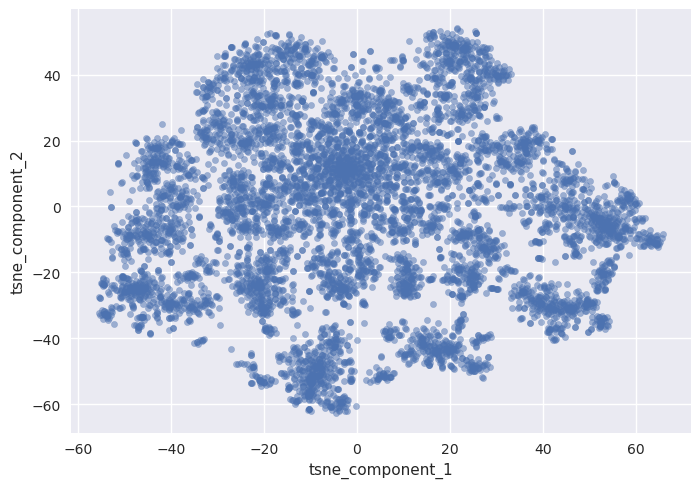

In [223]:
import hdbscan
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN

user_tag_pivot = df2.pivot_table(values="answerCode", index="userID", columns="KnowledgeTag").fillna(0)

tsne = TSNE(n_components=2, random_state=42)
tsne_user_result = tsne.fit_transform(user_tag_pivot.values)
tsne_user_df = pd.DataFrame(tsne_user_result, columns=['tsne_component_1', 'tsne_component_2'])
tsne_user_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5)

<AxesSubplot:xlabel='tsne_bg_component_1', ylabel='tsne_bg_component_2'>

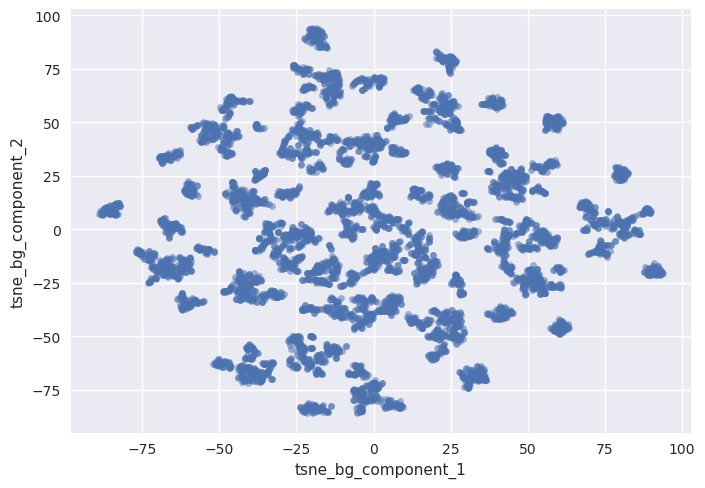

In [224]:
user_bigcategory_pivot = df2.pivot_table(values="answerCode", index="userID", columns="big_category").fillna(0)
tsne_bg = TSNE(n_components=2, random_state=42)
tsne_bg_result = tsne_bg.fit_transform(user_bigcategory_pivot.values)
tsne_bg_df = pd.DataFrame(tsne_bg_result, columns=['tsne_bg_component_1', 'tsne_bg_component_2'])
tsne_bg_df.plot(kind='scatter',x='tsne_bg_component_1', y='tsne_bg_component_2',alpha=0.5)

24

<AxesSubplot:xlabel='tsne_component_1', ylabel='tsne_component_2'>

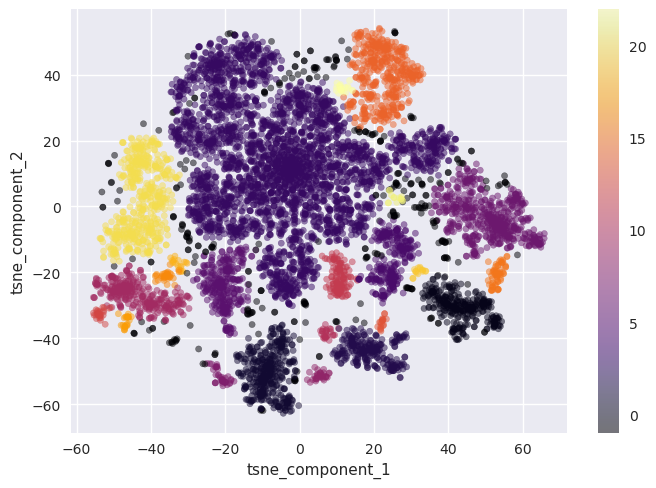

In [225]:
dbscan = DBSCAN(eps=2.6, min_samples=14, metric='euclidean')
dbscan_labels = dbscan.fit_predict(tsne_user_result)
n_cluster = len(set(dbscan_labels))
n_cluster
# pd.Series(dbscan_labels).value_counts()
tsne_user_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=dbscan_labels, colormap='inferno')

101

<AxesSubplot:xlabel='tsne_component_1', ylabel='tsne_component_2'>

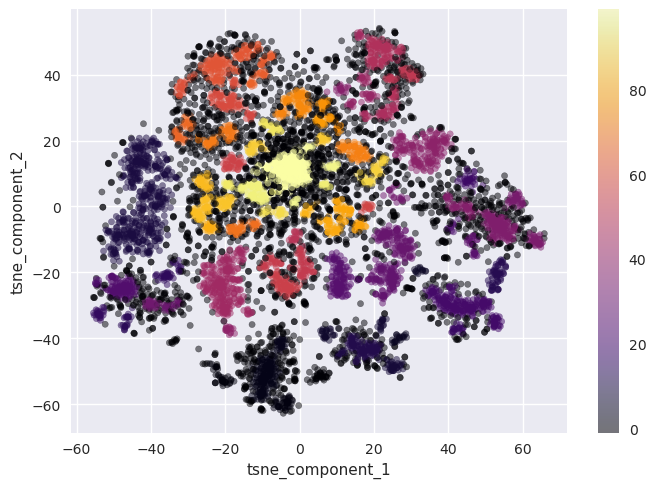

In [226]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
hdbscan_labels = clusterer.fit_predict(tsne_user_result)
n_cluster = len(set(hdbscan_labels))
n_cluster
# pd.Series(hdbscan_labels).value_counts()
tsne_user_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=hdbscan_labels, colormap='inferno')

<AxesSubplot:xlabel='tsne_component_1', ylabel='tsne_component_2'>

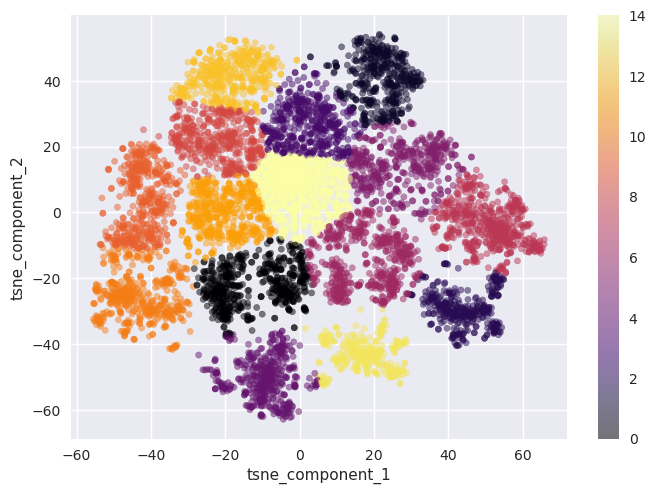

In [227]:
number_of_clusters=15
kmeans = KMeans(n_clusters=number_of_clusters, n_init=number_of_clusters+5, random_state=42)
kmeans_labels=kmeans.fit_predict(tsne_user_result)
tsne_user_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=kmeans_labels, colormap='inferno')

<AxesSubplot:xlabel='tsne_component_1', ylabel='tsne_component_2'>

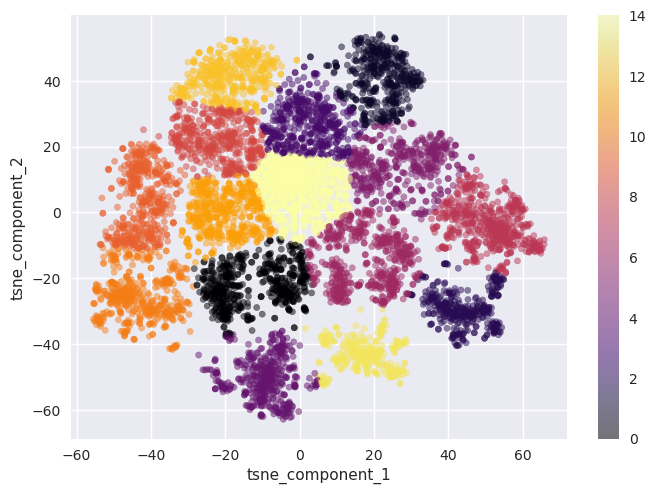

In [308]:
number_of_clusters=15
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init=number_of_clusters, random_state=42)
kmeans_labels=kmeans.fit_predict(tsne_user_result)
tsne_user_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=kmeans_labels, colormap='inferno')

### df2에 클러스터 저장

In [309]:
len(user_tag_pivot.index)
len(kmeans_labels)

7442

7442

In [230]:
tsne_user_dict = dict(zip(user_tag_pivot.index,kmeans_labels))

In [232]:
df2['user_tag_cluster'] = df2.userID.map(tsne_user_dict)

In [233]:
df2.user_tag_cluster.value_counts()

0     318750
7     311953
10    288221
4     270639
13    249208
2     247635
6     231670
5     105899
11     94423
9      83729
1      77929
12     72929
8      61084
14     59653
3      52978
Name: user_tag_cluster, dtype: int64

## tag user

<AxesSubplot:xlabel='tsne_component_1', ylabel='tsne_component_2'>

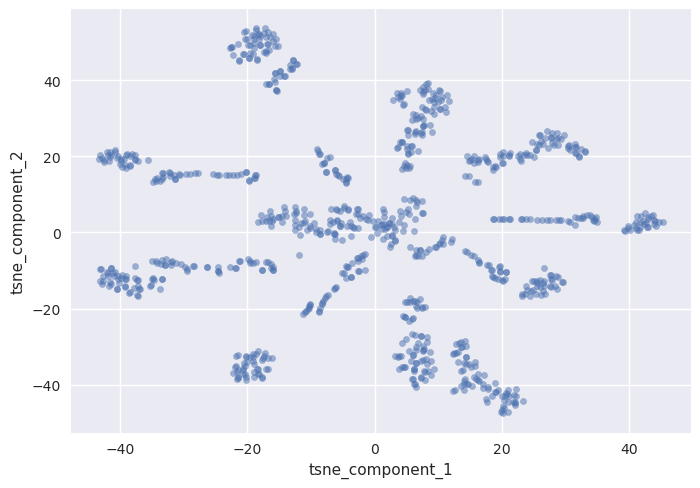

In [234]:
tag_user_pivot = df2.pivot_table(values="answerCode", index="KnowledgeTag", columns="userID").fillna(0)

tsne = TSNE(n_components=2, random_state=42)
tsne_tag_result = tsne.fit_transform(tag_user_pivot.values)
tsne_tag_df = pd.DataFrame(tsne_tag_result, columns=['tsne_component_1', 'tsne_component_2'])
tsne_tag_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5)

23

<AxesSubplot:xlabel='tsne_component_1', ylabel='tsne_component_2'>

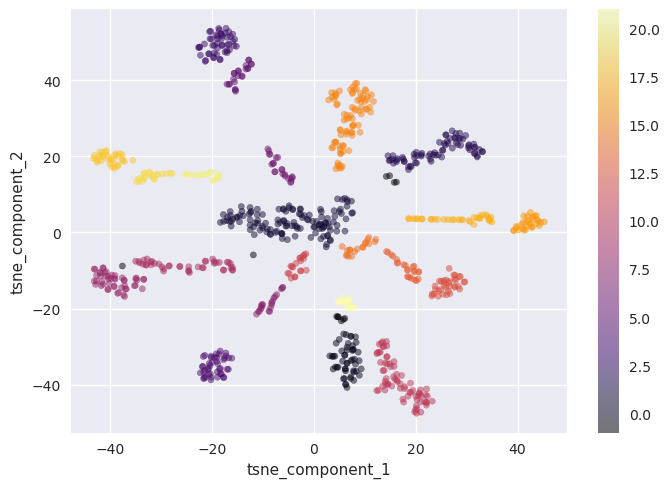

In [235]:
dbscan = DBSCAN(eps=2.6, min_samples=7, metric='euclidean')
dbscan_labels = dbscan.fit_predict(tsne_tag_result)
n_cluster = len(set(dbscan_labels))
n_cluster
# pd.Series(dbscan_labels).value_counts()
tsne_tag_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=dbscan_labels, colormap='inferno')

<AxesSubplot:xlabel='tsne_component_1', ylabel='tsne_component_2'>

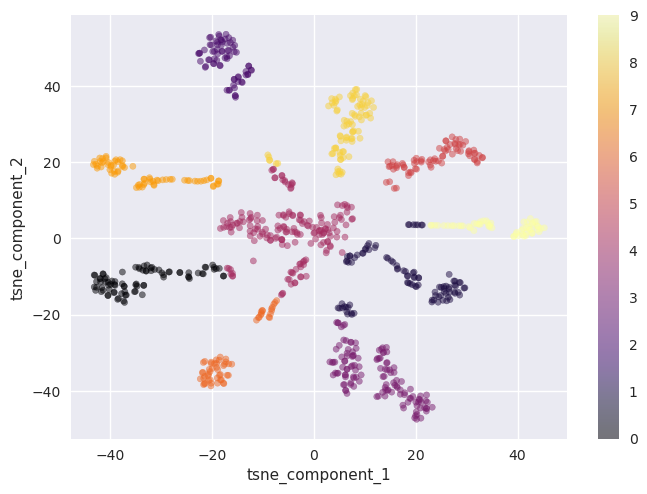

In [237]:
number_of_clusters=10
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init=number_of_clusters, random_state=42)
kmeans_labels=kmeans.fit_predict(tsne_tag_result)
tsne_tag_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=kmeans_labels, colormap='inferno')

24

<AxesSubplot:xlabel='tsne_component_1', ylabel='tsne_component_2'>

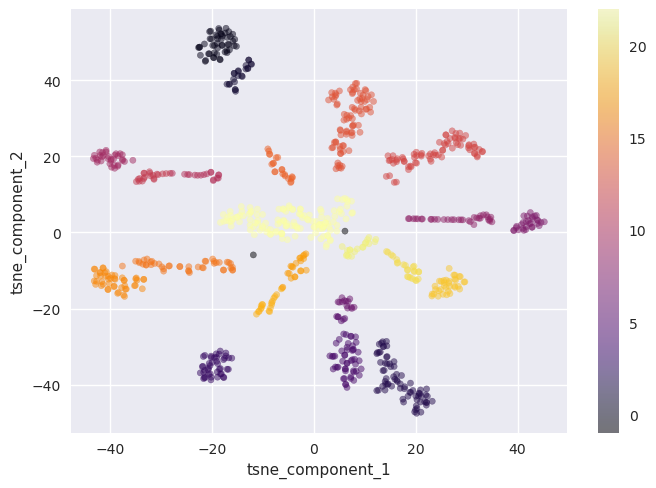

In [238]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True)
hdbscan_labels = clusterer.fit_predict(tsne_tag_result)
n_cluster = len(set(hdbscan_labels))
n_cluster
# pd.Series(hdbscan_labels).value_counts()
tsne_tag_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=hdbscan_labels, colormap='inferno')

In [273]:
tsne_tag_df['labels'] = hdbscan_labels

In [274]:
tsne_tag_df.labels.value_counts()

 22    129
 13     82
 12     76
 2      71
 4      51
 0      50
 16     48
 15     44
 3      44
 19     35
 8      34
 9      33
 7      30
 20     24
 1      23
 14     22
 11     20
 17     20
 21     19
 18     19
 10     17
 6      13
 5       6
-1       2
Name: labels, dtype: int64

In [276]:
tsne_tag_df.loc[tsne_tag_df.lables==-1,'labels']=22

In [277]:
tsne_tag_df.labels.value_counts()

22    131
13     82
12     76
2      71
4      51
0      50
16     48
15     44
3      44
19     35
8      34
9      33
7      30
20     24
1      23
14     22
11     20
17     20
21     19
18     19
10     17
6      13
5       6
Name: labels, dtype: int64

<AxesSubplot:xlabel='tsne_component_1', ylabel='tsne_component_2'>

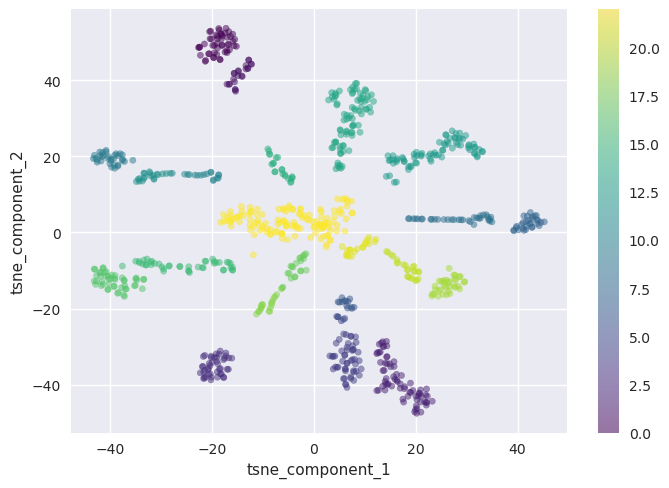

In [282]:
tsne_tag_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=tsne_tag_df.labels, colormap='viridis')

### df2에 클러스터 저장

In [285]:
tsne_tag_dict = dict(zip(tag_user_pivot.index, tsne_tag_df.labels))

In [286]:
df2['tag_cluster'] = df2.KnowledgeTag.map(tsne_tag_dict)

In [287]:
df2.tag_cluster.value_counts()

12    174500
0     167350
7     165550
3     162600
19    159000
9     158400
16    154500
2     145650
15    141600
22    141550
8     138200
13    135250
4      97200
20     88200
18     85550
11     84600
1      74500
14     63550
17     54400
10     54350
21     52100
6      18500
5       9600
Name: tag_cluster, dtype: int64

<AxesSubplot:xlabel='bins'>

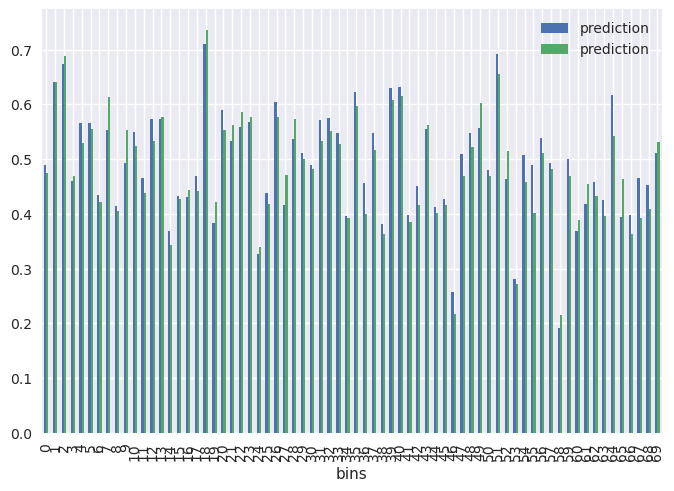

In [317]:
bins=70
auc819 = pd.read_csv('../LGBM/output/12_05_Mon_LGBM_elo만_추가_lr_0_023_피처_32개.csv')
auc819['bins'] = pd.cut(auc819.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(auc819.bins.unique()))}
auc819['bins'] = auc819.bins.map(bins_map)
auc819_grp = auc819.groupby('bins').prediction.mean()

user_dfc2 = pd.read_csv('../LGBM/output/12_07_Wed_LGBM_Feature_Selection_ver2_1000_epochs_27개.csv')
user_dfc2['bins'] = pd.cut(user_dfc2.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(user_dfc2.bins.unique()))}
user_dfc2['bins'] = user_dfc2.bins.map(bins_map)
user_dfc2_grp = user_dfc2.groupby('bins').prediction.mean()
pd.concat([auc819_grp,user_dfc2_grp],axis=1).plot(kind='bar')

### elo 추가

In [293]:
df2 = apply_elo_granularity_feature_name(df2, "big_category")
df2 = apply_elo_granularity_feature_name(df2, "mid_category")
df2 = apply_elo_granularity_feature_name(df2, "user_tag_cluster")
df2 = apply_elo_granularity_feature_name(df2, "tag_cluster")

Dataset of shape (2526700, 51)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote', 'elo_assessmentItemID', 'elo_problem_num', 'user_tag_cluster', 'tag_cluster']
Parameter estimation is starting...


100%|██████████████████████████████| 2526700/2526700 [00:15<00:00, 160345.28it/s]


Theta & beta estimations on big_category are completed.
Dataset of shape (2526700, 52)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote', 'elo_assessmentItemID', 'elo_problem_num', 'user_tag_cluster', 'tag_cluster', 'elo_big_category']
Parameter estimation is starting...


100%|██████████████████████████████| 2526700/2526700 [00:16<00:00, 156352.44it/s]


Theta & beta estimations on mid_category are completed.
Dataset of shape (2526700, 53)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote', 'elo_assessmentItemID', 'elo_problem_num', 'user_tag_cluster', 'tag_cluster', 'elo_big_category', 'elo_mid_category']
Parameter estimation is starting...


100%|██████████████████████████████| 2526700/2526700 [00:15<00:00, 160632.29it/s]


Theta & beta estimations on user_tag_cluster are completed.
Dataset of shape (2526700, 54)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote', 'elo_assessmentItemID', 'elo_problem_num', 'user_tag_cluster', 'tag_cluster', 'elo_big_category', 'elo_mid_category', 'elo_user_tag_cluster']
Parameter es

100%|██████████████████████████████| 2526700/2526700 [00:15<00:00, 161414.16it/s]


Theta & beta estimations on tag_cluster are completed.


In [297]:
df2['elo_problem_num_difficulty'] = 1 - df2.elo_problem_num

In [299]:
df2['elo_assessmentItemID_difficulty'] = 1 - df2.elo_assessmentItemID

In [302]:
df2.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty',
       'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std',
       'assess_count', 'left_asymptote', 'elo_assessmentItemID',
       'elo_problem_num', 'user_tag_cluster', 'tag_cluster',
       'elo_big_category', 'elo_mid_category', 'elo_user_tag_cluster',
       'elo_tag_cl

In [289]:
cond1 = df2.kind=='test'
cond2 = df2.userID != df2.userID.shift(-7)

In [303]:
base = ['userID', 'assessmentItemID', 'answerCode', 'Timestamp','KnowledgeTag']
add_features = ['user_tag_cluster','elo_user_tag_cluster','tag_cluster','elo_tag_cluster']
cols = base + add_features
df2[cond1 & cond2][cols]

,userID,assessmentItemID,answerCode,Timestamp,KnowledgeTag,user_tag_cluster,elo_user_tag_cluster,tag_cluster,elo_tag_cluster
2983,3,A050133002,1,2020-10-26 13:09:28,5288,13,0.533082,1,0.767975
2984,3,A050133003,1,2020-10-26 13:10:22,5289,13,0.533082,1,0.767975
2985,3,A050133004,1,2020-10-26 13:12:11,5289,13,0.533082,1,0.767975
2986,3,A050133005,1,2020-10-26 13:12:36,5288,13,0.533082,1,0.767975
2987,3,A050133006,1,2020-10-26 13:12:52,5288,13,0.533082,1,0.767975
2988,3,A050133007,0,2020-10-26 13:13:11,5289,13,0.533082,1,0.767975
2989,3,A050133008,-1,2020-10-26 13:13:57,5289,13,0.533082,1,0.767975
3654,4,A070146002,1,2020-12-27 02:45:13,9080,0,0.513094,13,0.191621
3655,4,A070146003,0,2020-12-27 02:45:46,9080,0,0.513094,13,0.191621
3656,4,A070146004,1,2020-12-27 02:46:11,9079,0,0.513094,13,0.191621


In [57]:
df2[(df2.userID==7329)][cols]

,userID,assessmentItemID,answerCode,Timestamp,KnowledgeTag,assess_count,past_ass_correct
2524735,7329,A040198001,0,2020-01-02 12:50:41,2133,0,0.0
2524736,7329,A040198002,1,2020-01-02 12:50:46,2133,0,0.0
2524737,7329,A040198003,1,2020-01-02 12:50:56,2133,0,0.0
2524738,7329,A040198004,1,2020-01-02 12:51:04,2133,0,0.0
2524739,7329,A010014001,1,2020-01-05 03:56:54,5834,0,0.0
2524740,7329,A010014002,1,2020-01-05 03:57:18,5834,0,0.0
2524741,7329,A010014003,1,2020-01-05 03:57:36,5834,0,0.0
2524742,7329,A010014004,1,2020-01-05 03:58:20,5834,0,0.0
2524743,7329,A010014005,1,2020-01-05 03:58:39,5834,0,0.0
2524744,7329,A040196001,1,2020-10-07 10:30:54,2131,0,0.0


## 내보내기

In [300]:
df2.sort_values(by=['userID','Timestamp'], inplace=True)

In [301]:
export(df2, output='lgbm_tag_cluster.pkl')

Write: /opt/ml/input/data/lgbm_tag_cluster.pkl
